## Library Setup and Dependencies

In [83]:
import torch
import gzip
import matplotlib.pyplot as plt
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from typing import Tuple
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

## Device Setup
Using device: {cuda/cpu}

In [8]:
# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## Data Loading and Processing
Loading and Preparing MNIST Dataset

In [10]:
# Load data function
def load_data() -> Tuple[TensorDataset, TensorDataset, TensorDataset]:
    ((data_train, label_train), (data_test, label_test)) = torch.load(gzip.open('mnist.pkl.gz'))
    
    # Convert to float32 and move to device
    data_train = data_train.float().to(device)
    label_train = label_train.float().to(device)
    data_test = data_test.float().to(device)
    label_test = label_test.float().to(device)
    
    # Split training data into train and validation (80-20)
    train_size = int(0.8 * len(data_train))
    val_size = len(data_train) - train_size
    
    full_train_dataset = TensorDataset(data_train, label_train)
    train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])
    test_dataset = TensorDataset(data_test, label_test)
    
    return train_dataset, val_dataset, test_dataset

## Model Architecture
Deep MLP with 4 Hidden Layers

In [12]:
# deep MLP with 4 hidden layers
class DeepMLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(DeepMLP, self).__init__()
        self.hidden1 = nn.Linear(input_size, hidden_size)
        self.hidden2 = nn.Linear(hidden_size, hidden_size)
        self.hidden3 = nn.Linear(hidden_size, hidden_size)
        self.hidden4 = nn.Linear(hidden_size, hidden_size)
        self.relu = nn.ReLU()
        self.output = nn.Linear(hidden_size, output_size)
        
        # Move model to device
        self.to(device)
    
    def forward(self, x):
        x = self.relu(self.hidden1(x))
        x = self.relu(self.hidden2(x))
        x = self.relu(self.hidden3(x))
        x = self.relu(self.hidden4(x))
        x = self.output(x)
        return x

### Training Functions

In [14]:
# Training loop
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        correct = 0
        total = 0
        
        for data, labels in train_loader:
            # Move batch to device
            data = data.view(-1, input_size).to(device)
            labels = labels.to(device)
            
            outputs = model(data)
            loss = criterion(outputs, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            _, labels = torch.max(labels, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        train_accuracy = 100 * correct / total
        val_loss, val_accuracy = evaluate_model(model, val_loader, criterion)
        
        train_losses.append(train_loss / len(train_loader))
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)
        
        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Train Loss: {train_loss/len(train_loader):.4f}, "
              f"Train Accuracy: {train_accuracy:.2f}%, "
              f"Val Loss: {val_loss:.4f}, "
              f"Val Accuracy: {val_accuracy:.2f}%")

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
    plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    
    plt.show()

## Evaluation function

In [16]:
# Evaluation function
def evaluate_model(model, data_loader, criterion):
    model.eval()
    loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, labels in data_loader:
            # Move batch to device
            data = data.view(-1, input_size).to(device)
            labels = labels.to(device)
            
            outputs = model(data)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            _, labels = torch.max(labels, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    return loss / len(data_loader), accuracy

## Hyperparameter Search

In [ ]:
# Grid search function
def grid_search(train_dataset, val_dataset, test_dataset):
    learning_rates = [0.01, 0.001, 0.0001]
    hidden_sizes = [64, 128, 256]
    batch_sizes = [32, 64, 128]
    
    best_model = None
    best_val_accuracy = 0
    best_hyperparams = {}

    for lr in learning_rates:
        for hidden_size in hidden_sizes:
            for batch_size in batch_sizes:
                train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
                val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
                test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

                model = DeepMLP(input_size, hidden_size, output_size)
                criterion = nn.CrossEntropyLoss()
                optimizer = optim.Adam(model.parameters(), lr=lr)
                print("=====================")
                print(f"Training with learning rate: {lr}, hidden size: {hidden_size}, batch size: {batch_size}")

                # Training loop
                for epoch in range(num_epochs):
                    model.train()
                    train_loss = 0
                    correct = 0
                    total = 0
                    
                    for data, labels in train_loader:
                        # Move batch to device
                        data = data.view(-1, input_size).to(device)
                        labels = labels.to(device)
                        
                        outputs = model(data)
                        loss = criterion(outputs, labels)
                        
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()
                        
                        train_loss += loss.item()
                        _, predicted = torch.max(outputs.data, 1)
                        _, labels = torch.max(labels, 1)

                        total += labels.size(0)
                        correct += (predicted == labels).sum().item()
                    
                    train_accuracy = 100 * correct / total
                    val_loss, val_accuracy = evaluate_model(model, val_loader, criterion)
                    
                    print(f"Epoch [{epoch+1}/{num_epochs}], "
                          f"Train Loss: {train_loss/len(train_loader):.2f}, "
                          f"Train Accuracy: {train_accuracy:.2f}%, "
                          f"Val Loss: {val_loss:.2f}, "
                          f"Val Accuracy: {val_accuracy:.2f}%")

                if val_accuracy > best_val_accuracy:
                    best_val_accuracy = val_accuracy
                    best_model = model
                    best_hyperparams = {
                        "learning_rate": lr,
                        "hidden_size": hidden_size,
                        "batch_size": batch_size
                    }

    print(f"Best validation accuracy: {best_val_accuracy:.2f}%")
    print(f"Best hyperparameters: {best_hyperparams}")

    test_loader = DataLoader(test_dataset, batch_size=best_hyperparams["batch_size"], shuffle=False)
    test_loss, test_accuracy = evaluate_model(best_model, test_loader, criterion)
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")
    
    return best_hyperparams

In [44]:
# Load data
train_dataset, val_dataset, test_dataset = load_data()
# Run the grid search
best_hyperparams = grid_search(train_dataset, val_dataset, test_dataset)

C:\Users\ayoub\AppData\Local\Temp\ipykernel_14988\2175631639.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ((data_train, label_train), (data_test, label_test)) = torch

Training with learning rate: 0.01, hidden size: 64, batch size: 32
Epoch [1/10], Train Loss: 0.37, Train Accuracy: 89.65%, Val Loss: 0.26, Val Accuracy: 92.87%
Epoch [2/10], Train Loss: 0.23, Train Accuracy: 94.07%, Val Loss: 0.21, Val Accuracy: 94.55%
Epoch [3/10], Train Loss: 0.20, Train Accuracy: 94.95%, Val Loss: 0.22, Val Accuracy: 95.07%
Epoch [4/10], Train Loss: 0.19, Train Accuracy: 95.34%, Val Loss: 0.22, Val Accuracy: 94.92%
Epoch [5/10], Train Loss: 0.18, Train Accuracy: 95.52%, Val Loss: 0.26, Val Accuracy: 94.11%
Epoch [6/10], Train Loss: 0.15, Train Accuracy: 96.31%, Val Loss: 0.25, Val Accuracy: 94.31%
Epoch [7/10], Train Loss: 0.17, Train Accuracy: 95.80%, Val Loss: 0.22, Val Accuracy: 94.94%
Epoch [8/10], Train Loss: 0.15, Train Accuracy: 96.38%, Val Loss: 0.20, Val Accuracy: 95.96%
Epoch [9/10], Train Loss: 0.14, Train Accuracy: 96.59%, Val Loss: 0.19, Val Accuracy: 95.51%
Epoch [10/10], Train Loss: 0.18, Train Accuracy: 95.98%, Val Loss: 0.18, Val Accuracy: 96.10%
Tr

## Train the model with best param


Epoch [1/30], Train Loss: 0.3112, Train Accuracy: 90.30%, Val Loss: 0.1476, Val Accuracy: 95.31%
Epoch [2/30], Train Loss: 0.1194, Train Accuracy: 96.33%, Val Loss: 0.1068, Val Accuracy: 96.69%
Epoch [3/30], Train Loss: 0.0826, Train Accuracy: 97.43%, Val Loss: 0.1151, Val Accuracy: 96.68%
Epoch [4/30], Train Loss: 0.0623, Train Accuracy: 98.11%, Val Loss: 0.0955, Val Accuracy: 97.59%
Epoch [5/30], Train Loss: 0.0478, Train Accuracy: 98.51%, Val Loss: 0.1114, Val Accuracy: 97.17%
Epoch [6/30], Train Loss: 0.0432, Train Accuracy: 98.66%, Val Loss: 0.0937, Val Accuracy: 97.58%
Epoch [7/30], Train Loss: 0.0349, Train Accuracy: 98.91%, Val Loss: 0.1170, Val Accuracy: 97.25%
Epoch [8/30], Train Loss: 0.0315, Train Accuracy: 99.01%, Val Loss: 0.1082, Val Accuracy: 97.47%
Epoch [9/30], Train Loss: 0.0280, Train Accuracy: 99.12%, Val Loss: 0.1017, Val Accuracy: 97.62%
Epoch [10/30], Train Loss: 0.0255, Train Accuracy: 99.21%, Val Loss: 0.0919, Val Accuracy: 97.89%
Epoch [11/30], Train Loss: 0.

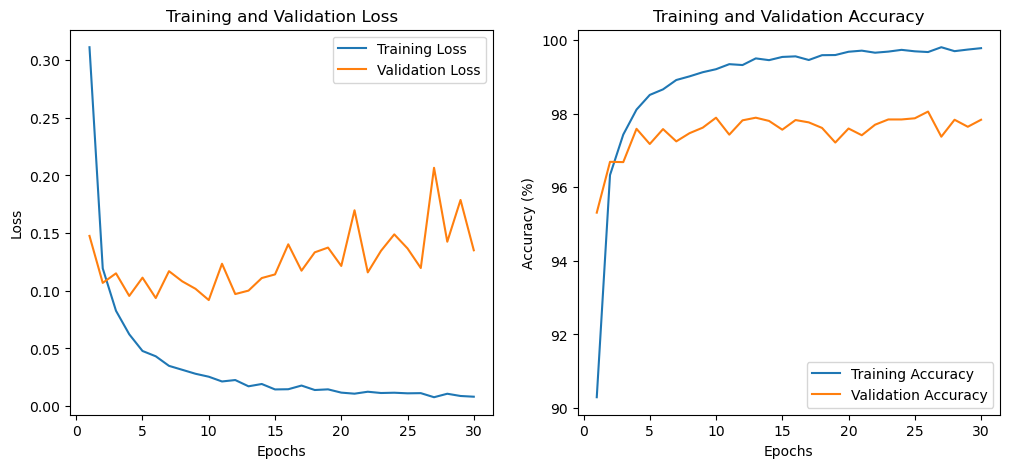

In [68]:
# Get the best hyperparameters and set up the model training with them
train_loader_with_best_parameter = DataLoader(train_dataset, batch_size=best_hyperparams["batch_size"], shuffle=True)
val_loader_with_best_parameter = DataLoader(val_dataset, batch_size=best_hyperparams["batch_size"], shuffle=True)

# Create the model with best parameters and move it to the device
model_with_best_param = DeepMLP(input_size, best_hyperparams["hidden_size"], output_size).to(device)

# Set up the optimizer and criterion
optimizer = optim.Adam(model_with_best_param.parameters(), lr=best_hyperparams["learning_rate"])
criterion = nn.CrossEntropyLoss()

# Train the model with best parameters
train_model(model_with_best_param, train_loader_with_best_parameter, val_loader_with_best_parameter, criterion, optimizer, 30)

## Function to test hyperparameters
The influence of each hyperparameter on the performance. (we will take the best hyperparametes as fixed variables while we change the variable that will we test on )

In [79]:
# Function to test hyperparameters
def test_hyperparameters(hyperparam_name, values):
    results = {}
    for value in values:
        print(f"Testing {hyperparam_name} = {value}")
        
        if hyperparam_name == 'learning_rate':
            learning_rate = value
            hidden_size = 256
            batch_size = 64
        elif hyperparam_name == 'hidden_size':
            learning_rate = 0.001
            hidden_size = value
            batch_size = 64
        elif hyperparam_name == 'batch_size':
            learning_rate = 0.001
            hidden_size = 256
            batch_size = value
        else:
            raise ValueError("Unsupported hyperparameter name.")
        
        train_dataset, val_dataset, test_dataset = load_data()
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
        
        model = DeepMLP(input_size, hidden_size, output_size)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

        train_losses, val_losses = [], []
        train_accuracies, val_accuracies = [], []

        print(f"Training with learning rate: {learning_rate}, hidden size: {hidden_size}, batch size: {batch_size}")

        for epoch in range(num_epochs):
            model.train()
            train_loss = 0
            correct = 0
            total = 0
            
            for data, labels in train_loader:
                # Move batch to device
                data = data.view(-1, input_size).to(device)
                labels = labels.to(device)
                
                outputs = model(data)
                loss = criterion(outputs, labels)
                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                train_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                _, labels = torch.max(labels, 1)

                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            
            train_accuracy = 100 * correct / total
            val_loss, val_accuracy = evaluate_model(model, val_loader, criterion)

            train_losss = train_loss / len(train_loader)
            train_losses.append(train_losss)
            val_losses.append(val_loss)
            train_accuracies.append(train_accuracy)
            val_accuracies.append(val_accuracy)

            print(f"Epoch [{epoch+1}/{num_epochs}], "
                  f"Train Loss: {train_loss/len(train_loader):.2f}, "
                  f"Train Accuracy: {train_accuracy:.2f}%, "
                  f"Val Loss: {val_loss:.2f}, "
                  f"Val Accuracy: {val_accuracy:.2f}%")
            
        results[value] = {
            'train_losses': train_losses,
            'val_accuracies': val_accuracies
        }
    
    return results

## The influence of learning rate

Testing learning_rate = 0.001


C:\Users\ayoub\AppData\Local\Temp\ipykernel_14988\2175631639.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ((data_train, label_train), (data_test, label_test)) = torch

Training with learning rate: 0.001, hidden size: 256, batch size: 64
Epoch [1/10], Train Loss: 0.30, Train Accuracy: 90.70%, Val Loss: 0.15, Val Accuracy: 95.38%
Epoch [2/10], Train Loss: 0.11, Train Accuracy: 96.50%, Val Loss: 0.12, Val Accuracy: 96.33%
Epoch [3/10], Train Loss: 0.08, Train Accuracy: 97.48%, Val Loss: 0.11, Val Accuracy: 96.62%
Epoch [4/10], Train Loss: 0.06, Train Accuracy: 98.04%, Val Loss: 0.10, Val Accuracy: 97.29%
Epoch [5/10], Train Loss: 0.05, Train Accuracy: 98.46%, Val Loss: 0.09, Val Accuracy: 97.46%
Epoch [6/10], Train Loss: 0.04, Train Accuracy: 98.75%, Val Loss: 0.11, Val Accuracy: 97.18%
Epoch [7/10], Train Loss: 0.04, Train Accuracy: 98.79%, Val Loss: 0.09, Val Accuracy: 97.81%
Epoch [8/10], Train Loss: 0.03, Train Accuracy: 99.12%, Val Loss: 0.09, Val Accuracy: 97.72%
Epoch [9/10], Train Loss: 0.03, Train Accuracy: 99.13%, Val Loss: 0.10, Val Accuracy: 97.55%
Epoch [10/10], Train Loss: 0.02, Train Accuracy: 99.29%, Val Loss: 0.11, Val Accuracy: 97.41%


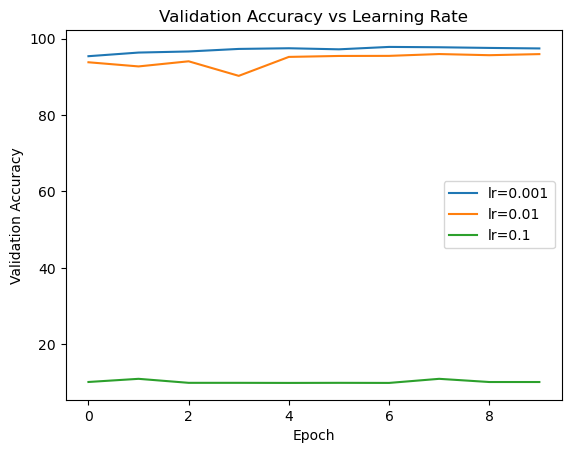

In [81]:
# Test learning rate
learning_rates = [0.001, 0.01, 0.1]
learning_rate_results = test_hyperparameters('learning_rate', learning_rates)
# Plot results
for lr, result in learning_rate_results.items():
    plt.plot(result['val_accuracies'], label=f'lr={lr}')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy vs Learning Rate')
plt.legend()
plt.show()

## The influence of hidden size

Testing hidden_size = 64
Training with learning rate: 0.001, hidden size: 64, batch size: 64
Epoch [1/10], Train Loss: 0.48, Train Accuracy: 84.85%, Val Loss: 0.25, Val Accuracy: 92.25%
Epoch [2/10], Train Loss: 0.19, Train Accuracy: 94.38%, Val Loss: 0.17, Val Accuracy: 94.90%
Epoch [3/10], Train Loss: 0.13, Train Accuracy: 95.88%, Val Loss: 0.15, Val Accuracy: 95.59%
Epoch [4/10], Train Loss: 0.11, Train Accuracy: 96.72%, Val Loss: 0.12, Val Accuracy: 96.26%
Epoch [5/10], Train Loss: 0.09, Train Accuracy: 97.30%, Val Loss: 0.10, Val Accuracy: 96.90%
Epoch [6/10], Train Loss: 0.07, Train Accuracy: 97.73%, Val Loss: 0.11, Val Accuracy: 96.69%
Epoch [7/10], Train Loss: 0.07, Train Accuracy: 97.95%, Val Loss: 0.12, Val Accuracy: 96.33%
Epoch [8/10], Train Loss: 0.06, Train Accuracy: 98.21%, Val Loss: 0.10, Val Accuracy: 97.01%
Epoch [9/10], Train Loss: 0.05, Train Accuracy: 98.39%, Val Loss: 0.10, Val Accuracy: 97.22%
Epoch [10/10], Train Loss: 0.04, Train Accuracy: 98.50%, Val Loss: 0.1

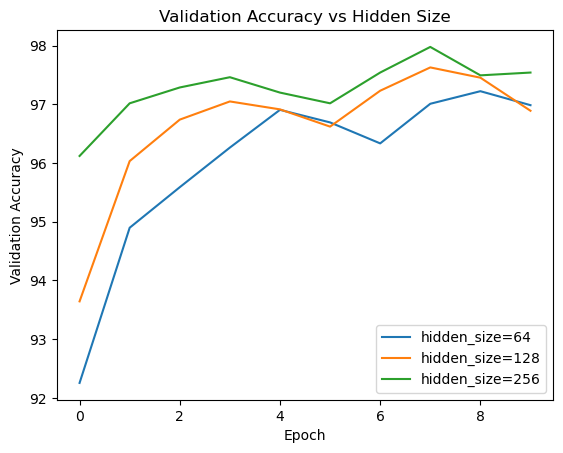

In [85]:
# Test hidden size
hidden_sizes = [64, 128, 256]
hidden_size_results = test_hyperparameters('hidden_size', hidden_sizes)
# Plot results
for hs, result in hidden_size_results.items():
    plt.plot(result['val_accuracies'], label=f'hidden_size={hs}')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy vs Hidden Size')
plt.legend()
plt.show()

## the influence of batch size

Testing batch_size = 32
Training with learning rate: 0.001, hidden size: 256, batch size: 32
Epoch [1/10], Train Loss: 0.29, Train Accuracy: 90.88%, Val Loss: 0.14, Val Accuracy: 96.04%
Epoch [2/10], Train Loss: 0.12, Train Accuracy: 96.53%, Val Loss: 0.12, Val Accuracy: 96.74%
Epoch [3/10], Train Loss: 0.08, Train Accuracy: 97.54%, Val Loss: 0.11, Val Accuracy: 96.80%
Epoch [4/10], Train Loss: 0.07, Train Accuracy: 98.02%, Val Loss: 0.12, Val Accuracy: 97.05%
Epoch [5/10], Train Loss: 0.05, Train Accuracy: 98.35%, Val Loss: 0.10, Val Accuracy: 97.59%
Epoch [6/10], Train Loss: 0.04, Train Accuracy: 98.65%, Val Loss: 0.10, Val Accuracy: 97.18%
Epoch [7/10], Train Loss: 0.04, Train Accuracy: 98.83%, Val Loss: 0.10, Val Accuracy: 97.49%
Epoch [8/10], Train Loss: 0.04, Train Accuracy: 98.97%, Val Loss: 0.11, Val Accuracy: 97.70%
Epoch [9/10], Train Loss: 0.03, Train Accuracy: 99.03%, Val Loss: 0.10, Val Accuracy: 97.90%
Epoch [10/10], Train Loss: 0.03, Train Accuracy: 99.20%, Val Loss: 0.1

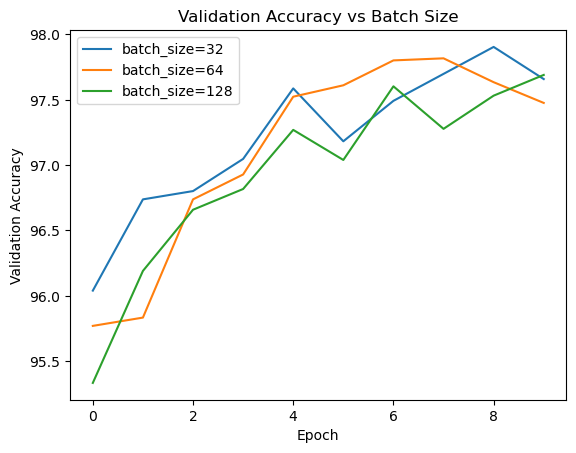

In [86]:
# Test batch size
batch_sizes = [32, 64, 128]
batch_size_results = test_hyperparameters('batch_size', batch_sizes)
# Plot results
for bs, result in batch_size_results.items():
    plt.plot(result['val_accuracies'], label=f'batch_size={bs}')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy vs Batch Size')
plt.legend()
plt.show()